# Diversified vs. Tech Portfolio Analysis

## Project Setup

This notebook requires several Python libraries. They can be installed via:
```bash
pip install -r requirements.txt
```
Helper functions are imported from 'utils.py'

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.stats as stats
import os

from utils import get_data, quarterly_rebalancing


plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
%config InlineBackend.figure_format = 'retina'

In [2]:
tickers = ['XLK', 'SPY', 'XLF', 'XLE', 'XLV', 'XLI', 'XLP', 'XLU']
prices_df = get_data(tickers)
prices_df.head()

Loading data from local file...


,SPY,XLE,XLF,XLI,XLK,XLP,XLU,XLV
Date,,,,,,,,
2014-01-02,149.840530,56.203926,14.236197,41.767387,30.573997,31.333782,25.677317,45.763630
2014-01-03,149.815994,55.997787,14.334420,41.880863,30.427132,31.274738,25.594910,45.871532
2014-01-06,149.381851,56.075111,14.347518,41.637684,30.375305,31.156631,25.636116,45.680614
2014-01-07,150.299271,56.500244,14.354069,41.897072,30.651747,31.326403,25.862732,46.162067
2014-01-08,150.332031,56.107292,14.399901,41.824120,30.651747,31.090199,25.725388,46.568813


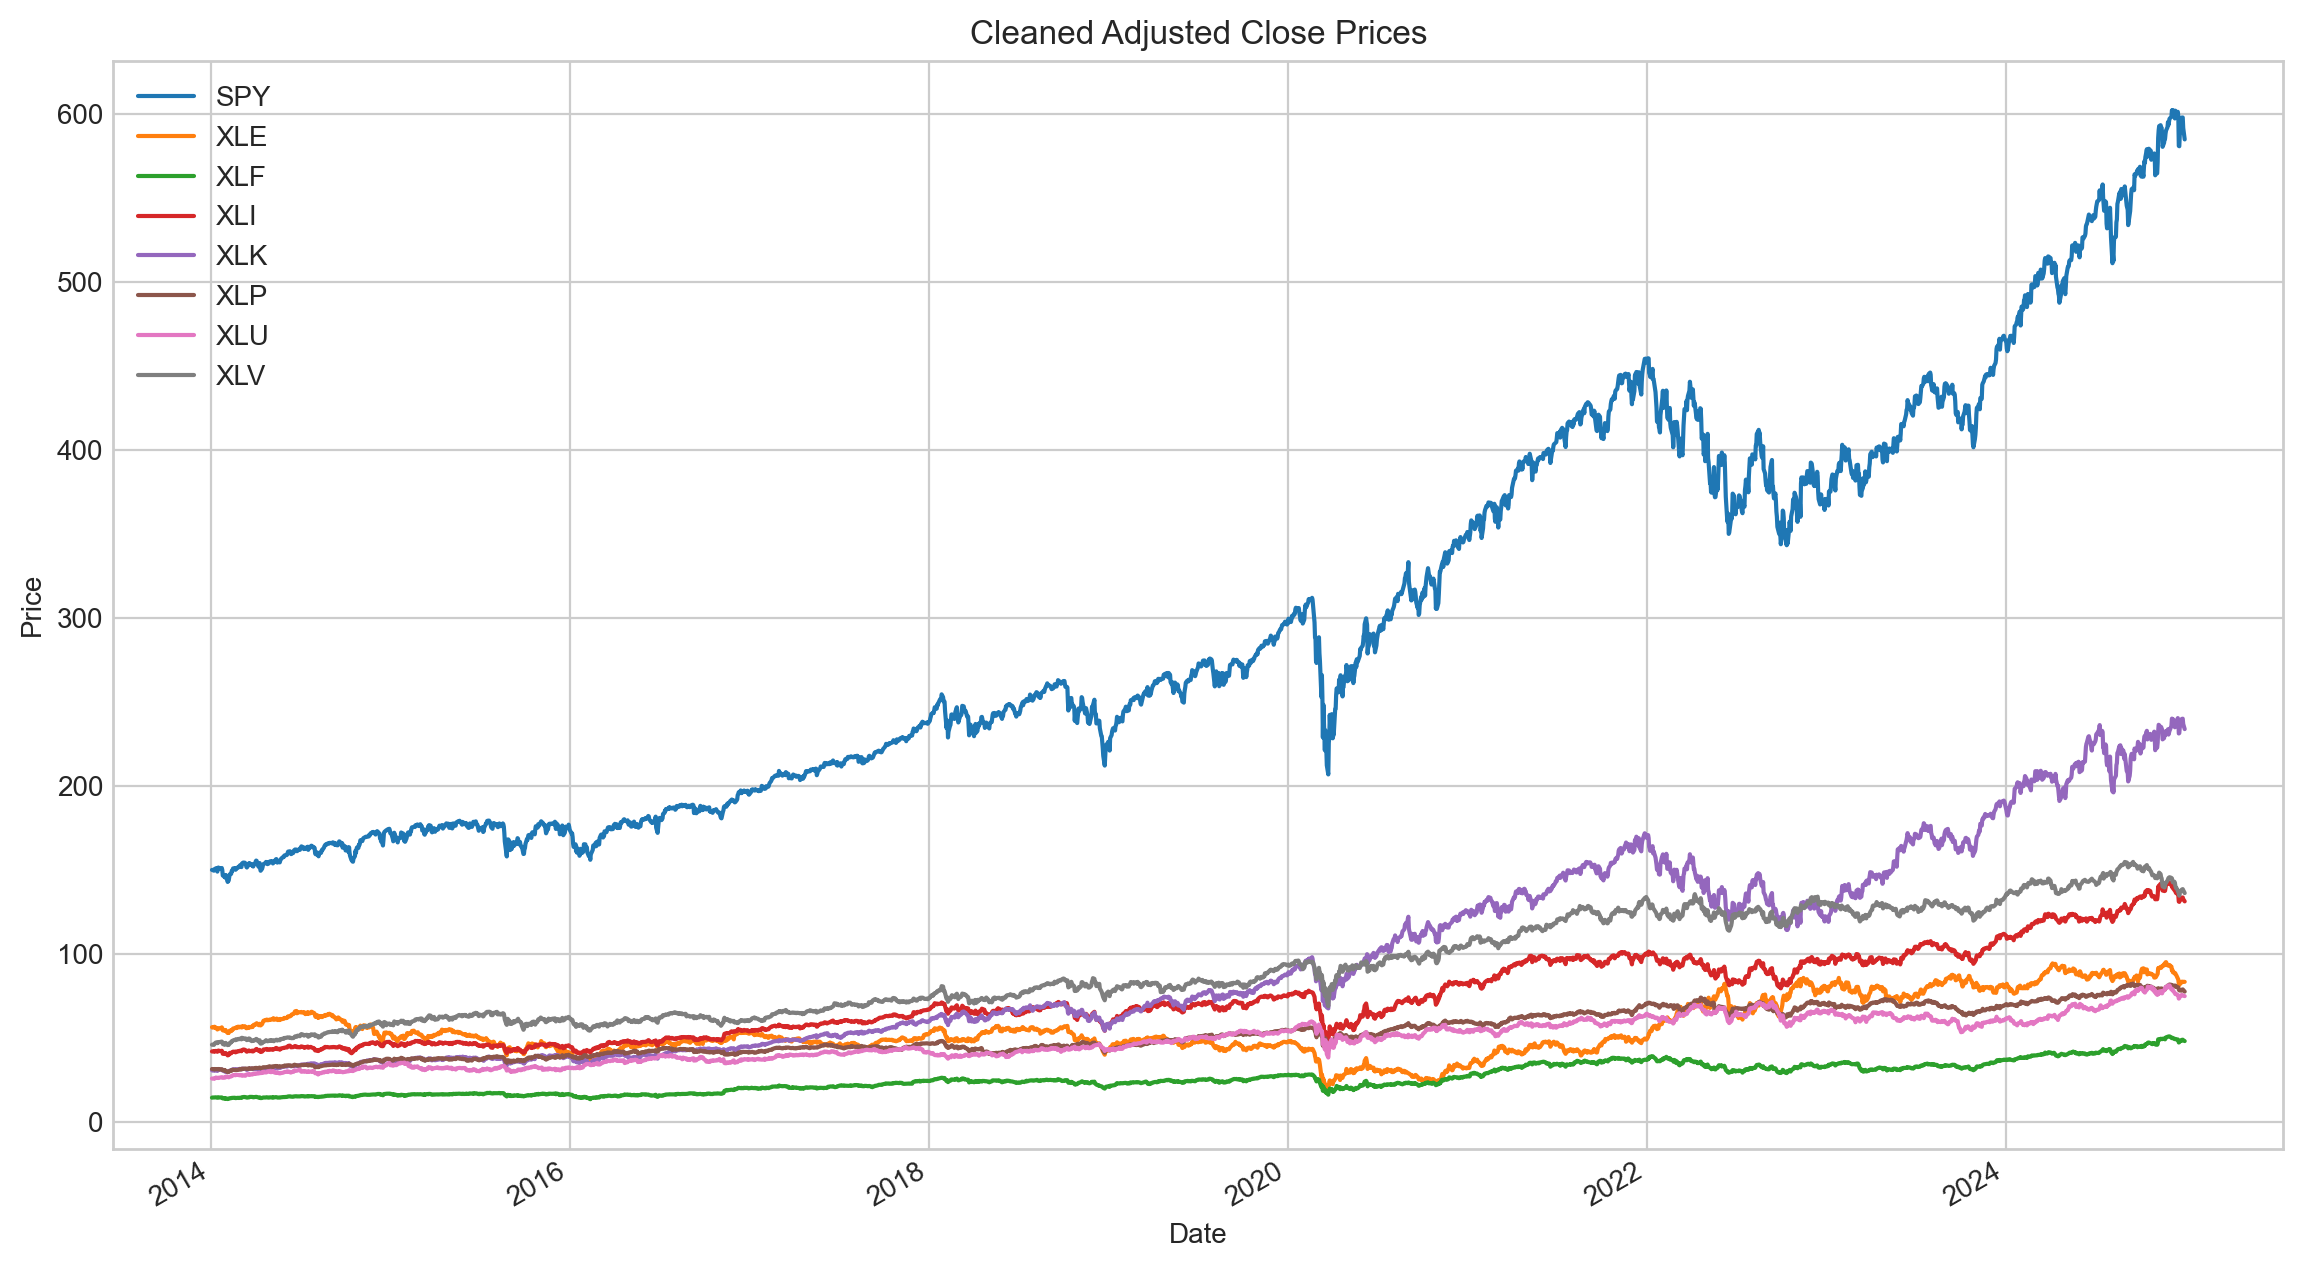

In [3]:
#Plot the data quickly to check for any outstanding issues:
prices_df.plot(title = 'Cleaned Adjusted Close Prices', figsize = (14, 8))
plt.ylabel('Price');

C:\Users\Dell\Projects\Finance\Diversified_vs_tech_portfolio\utils.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  div_returns = div_equity.pct_change().fillna(0)


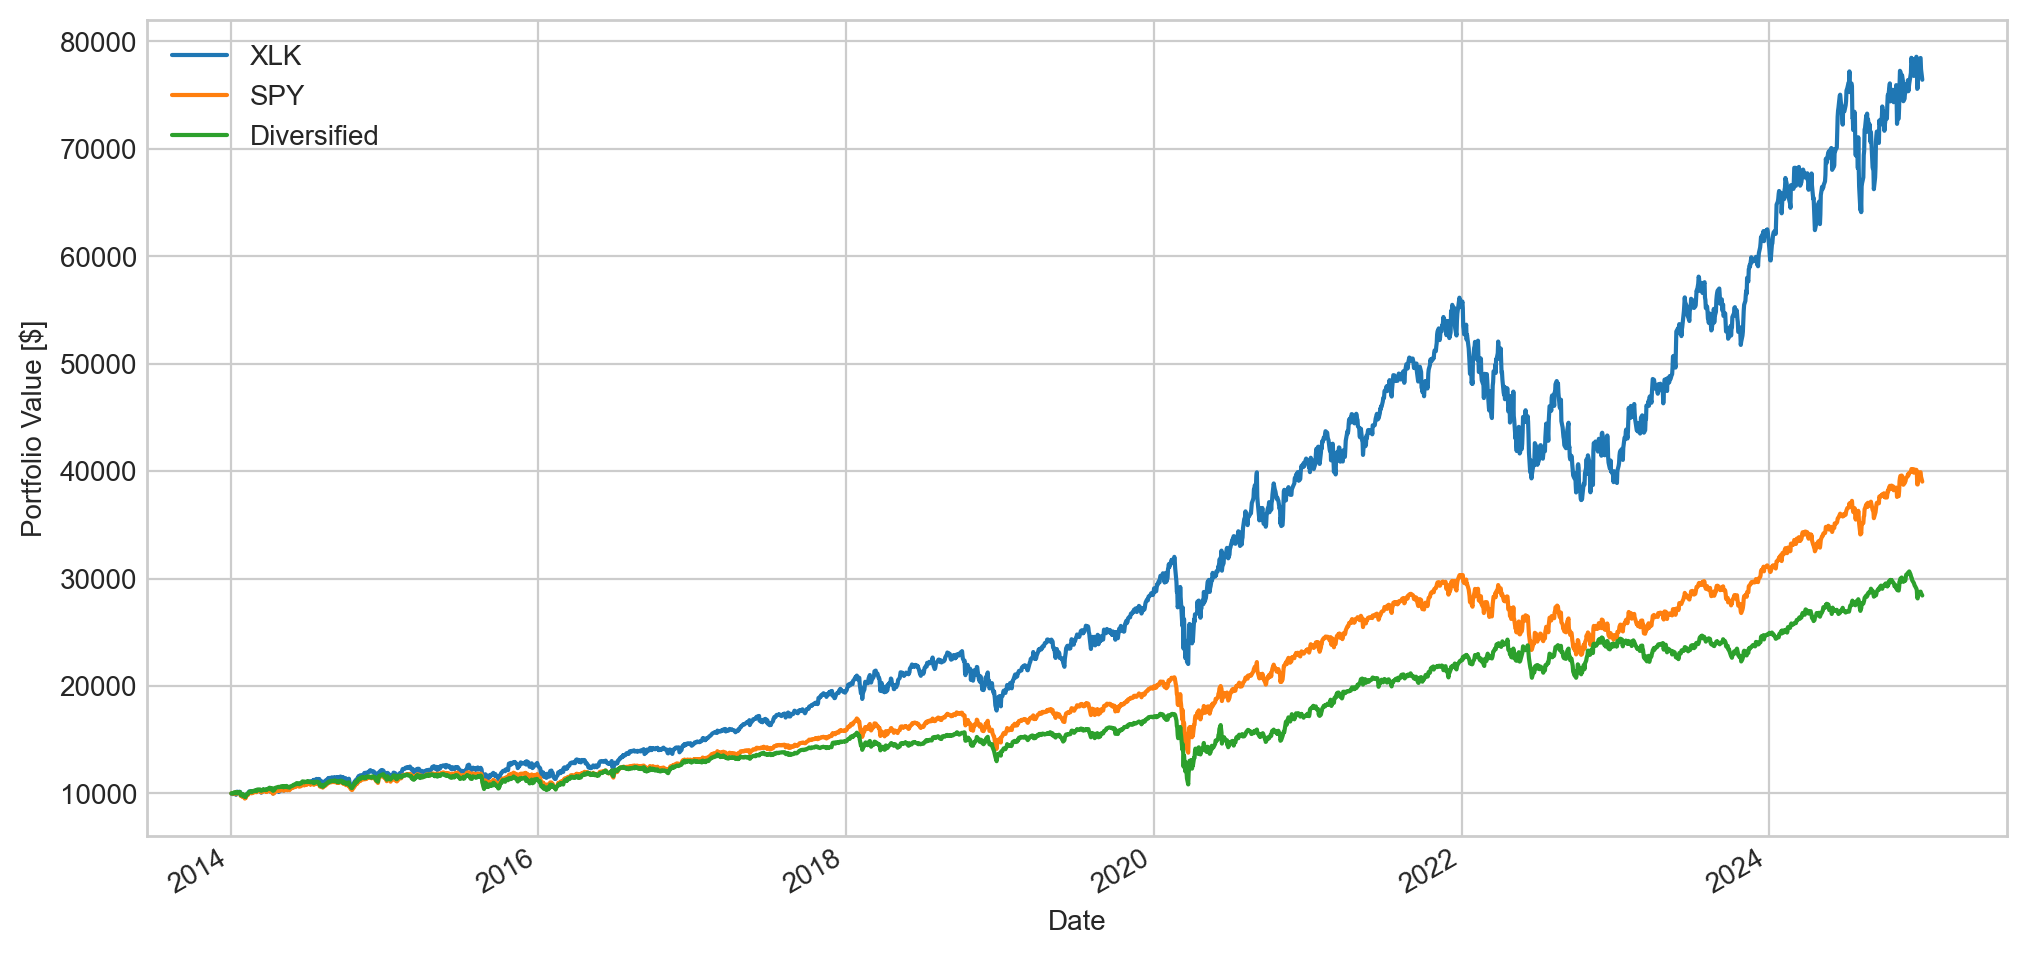

In [4]:
returns_df = prices_df.pct_change() #daily returns for each ETF
returns_df.iloc[0] = 0 #without this first row of .pct_change() would be NaN resulting in issues later
initial_capital = 10000

tech_returns = returns_df['XLK']
tech_equity = (1 + tech_returns).cumprod()
tech_equity *= initial_capital
tech_equity.plot()

bench_returns = returns_df['SPY']
bench_equity = (1 + bench_returns).cumprod()
bench_equity *= initial_capital
bench_equity.plot()

div_tickers = [i for i in tickers if i != 'SPY' and i != 'XLK'] #create portfolio of remaining tickers
target_weights = np.array([1/len(div_tickers)] * len(div_tickers))
div_equity, div_returns = quarterly_rebalancing(returns_df, div_tickers, target_weights, initial_capital)

div_equity.plot(label = 'Diversified')
plt.ylabel('Portfolio Value [$]')
plt.legend();

In [37]:
#Compound Annual Growth Rates calculations:
tech_cagr_pct = (tech_equity.iloc[-1]/initial_capital)**(1/10) - 1
bench_cagr_pct = (bench_equity.iloc[-1]/initial_capital)**(1/10) - 1
div_cagr_pct = (div_equity.iloc[-1]/initial_capital)**(1/10) - 1
print('CAGR for tech only (XLK) porfolio: ', round(tech_cagr_pct * 100, 2), '%\nCAGR for benchmark S&P500 porfolio: ', round(bench_cagr_pct * 100, 2), '%\nCAGR for diversified porfolio: ', round(div_cagr_pct * 100, 2), '%')

CAGR for tech only (XLK) porfolio:  {np.float64(22.553411389886225): 0.2} %
CAGR for benchmark S&P500 porfolio:  14.59 %
CAGR for diversified porfolio:  11.01 %


In [8]:
#returns volatility calculations:
tech_daily_volatility = tech_returns.std()
bench_daily_volatility = bench_returns.std()
div_daily_volatility = div_returns.std()

tech_annual_volatility = tech_daily_volatility * np.sqrt(252) #252 trading days in a year
bench_annual_volatility = bench_daily_volatility * np.sqrt(252)
div_annual_volatility = div_daily_volatility * np.sqrt(252)

print(tech_annual_volatility, '\n', bench_annual_volatility, '\n', div_annual_volatility)

0.22543605009514056 
 0.17132415046451183 
 0.16189509173359337


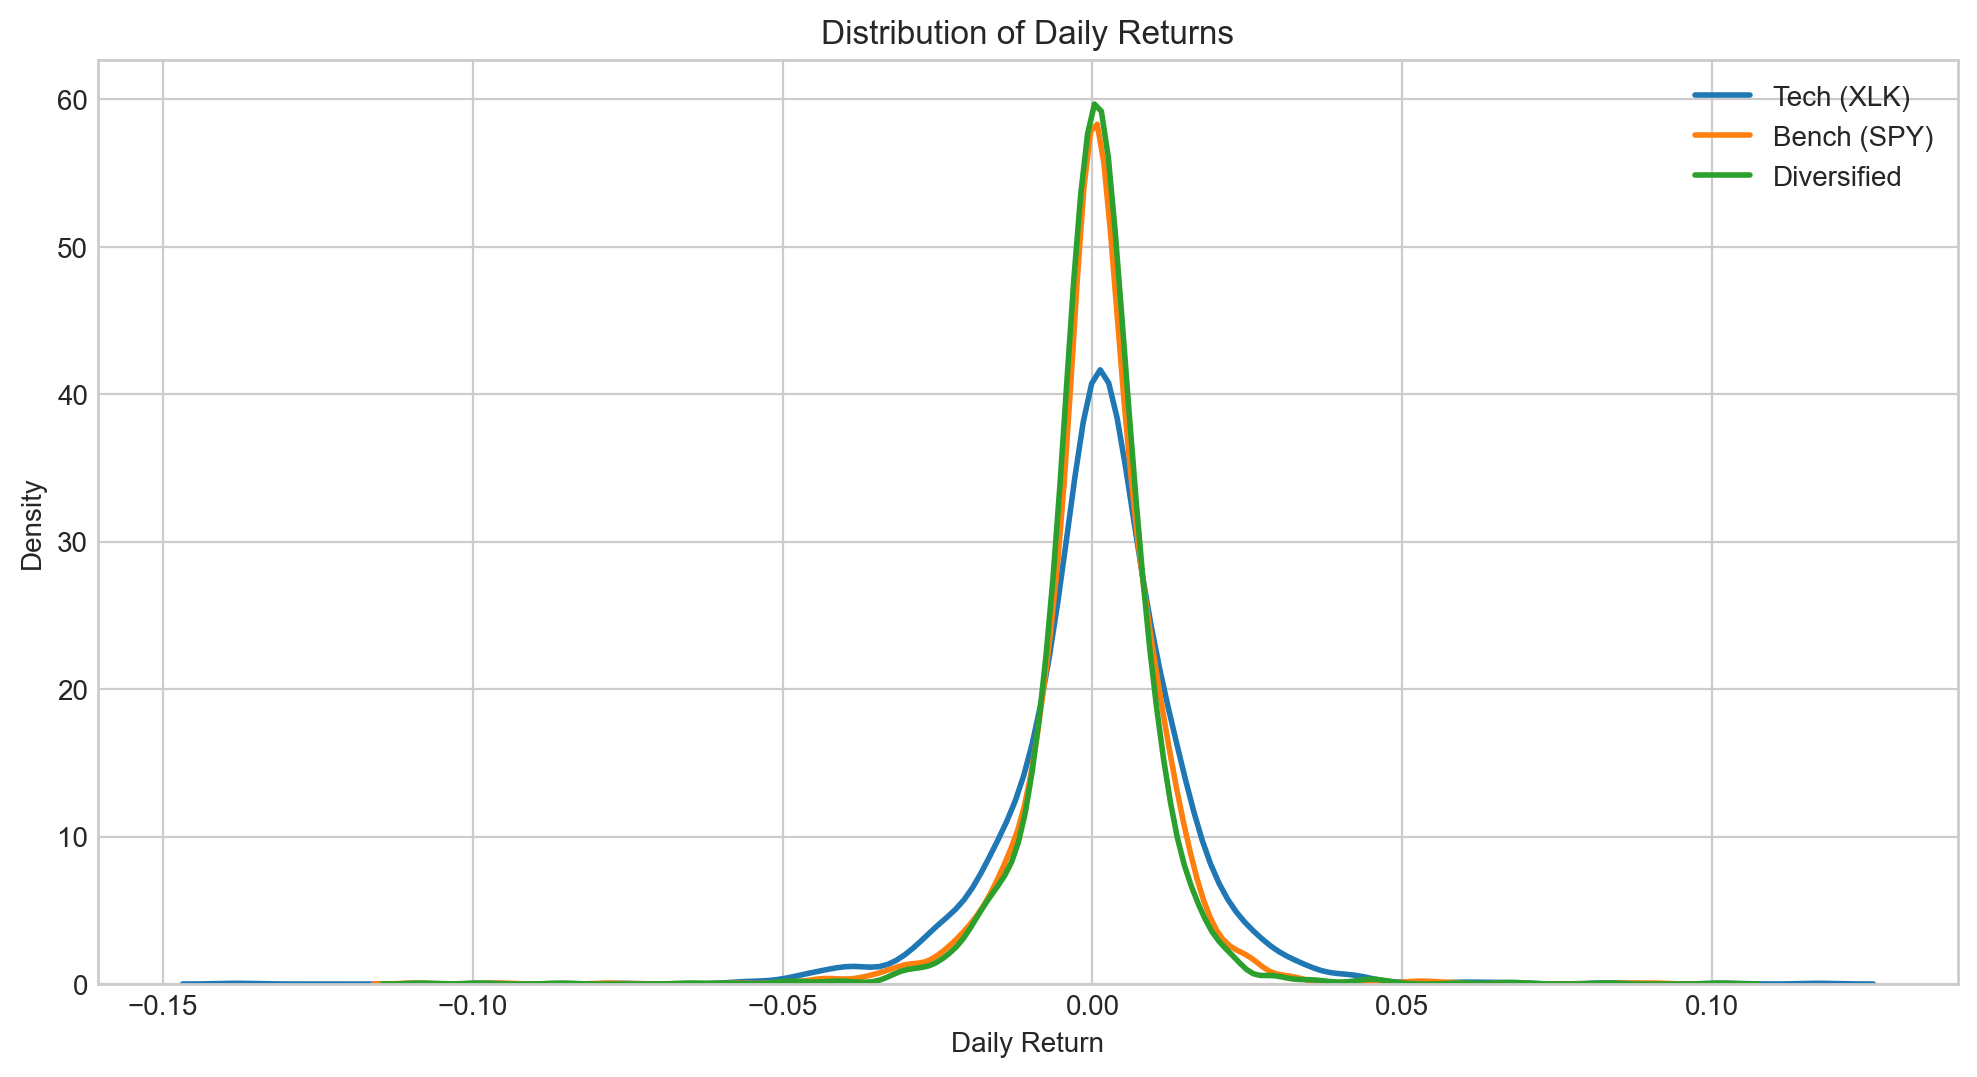

In [10]:
sns.kdeplot(tech_returns, label='Tech (XLK)', linewidth = 2)
sns.kdeplot(bench_returns, label='Bench (SPY)', linewidth = 2)
sns.kdeplot(div_returns, label='Diversified', linewidth = 2)

plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.legend()
plt.show()

In [40]:
#Maximum Drawdown calculations:
tech_equity_runnimg_max = tech_equity.cummax()
tech_dd_series = (tech_equity/tech_equity_runnimg_max) - 1
tech_max_dd = tech_dd_series.min()

bench_equity_runnimg_max = bench_equity.cummax()
bench_dd_series = (bench_equity/bench_equity_runnimg_max) - 1
bench_max_dd = bench_dd_series.min()

div_equity_runnimg_max = div_equity.cummax()
div_dd_series = (div_equity/div_equity_runnimg_max) - 1
div_max_dd = div_dd_series.min()

print(f'Maximum Drawdown for tech only (XLK) porfolio: {tech_max_dd:.2%}\nMaximum Drawdown for benchmark S&P500 porfolio: {bench_max_dd:.2%}\nMaximum Drawdown for diversified porfolio: {div_max_dd:.2%}')

Maximum Drawdown for tech only (XLK) porfolio: -33.56%
Maximum Drawdown for benchmark S&P500 porfolio: -33.72%
Maximum Drawdown for diversified porfolio: -37.75%


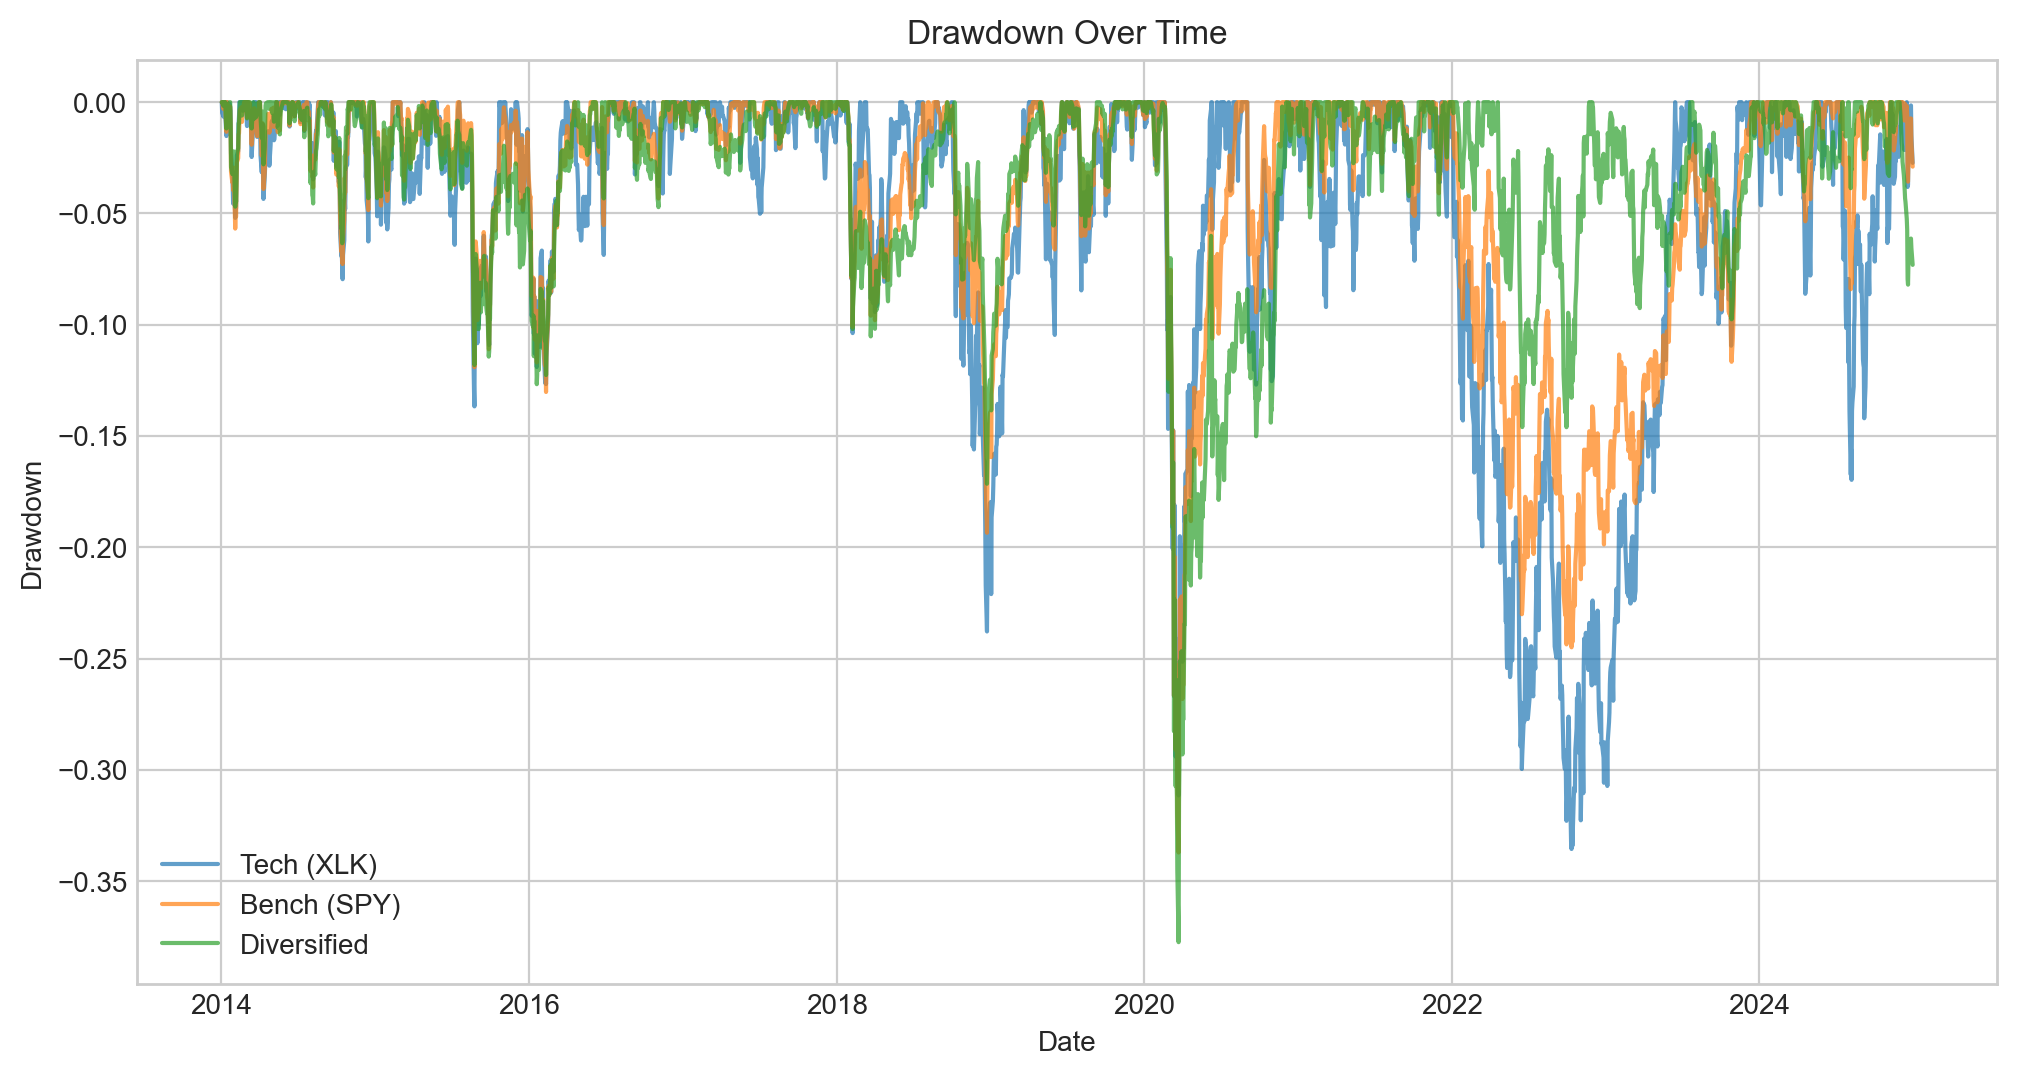

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(tech_dd_series, label='Tech (XLK)', alpha=0.7)
plt.plot(bench_dd_series, label='Bench (SPY)', alpha=0.7)
plt.plot(div_dd_series, label='Diversified', alpha=0.7)

plt.title('Drawdown Over Time')
plt.ylabel('Drawdown')
plt.xlabel('Date')
plt.legend()
plt.show()

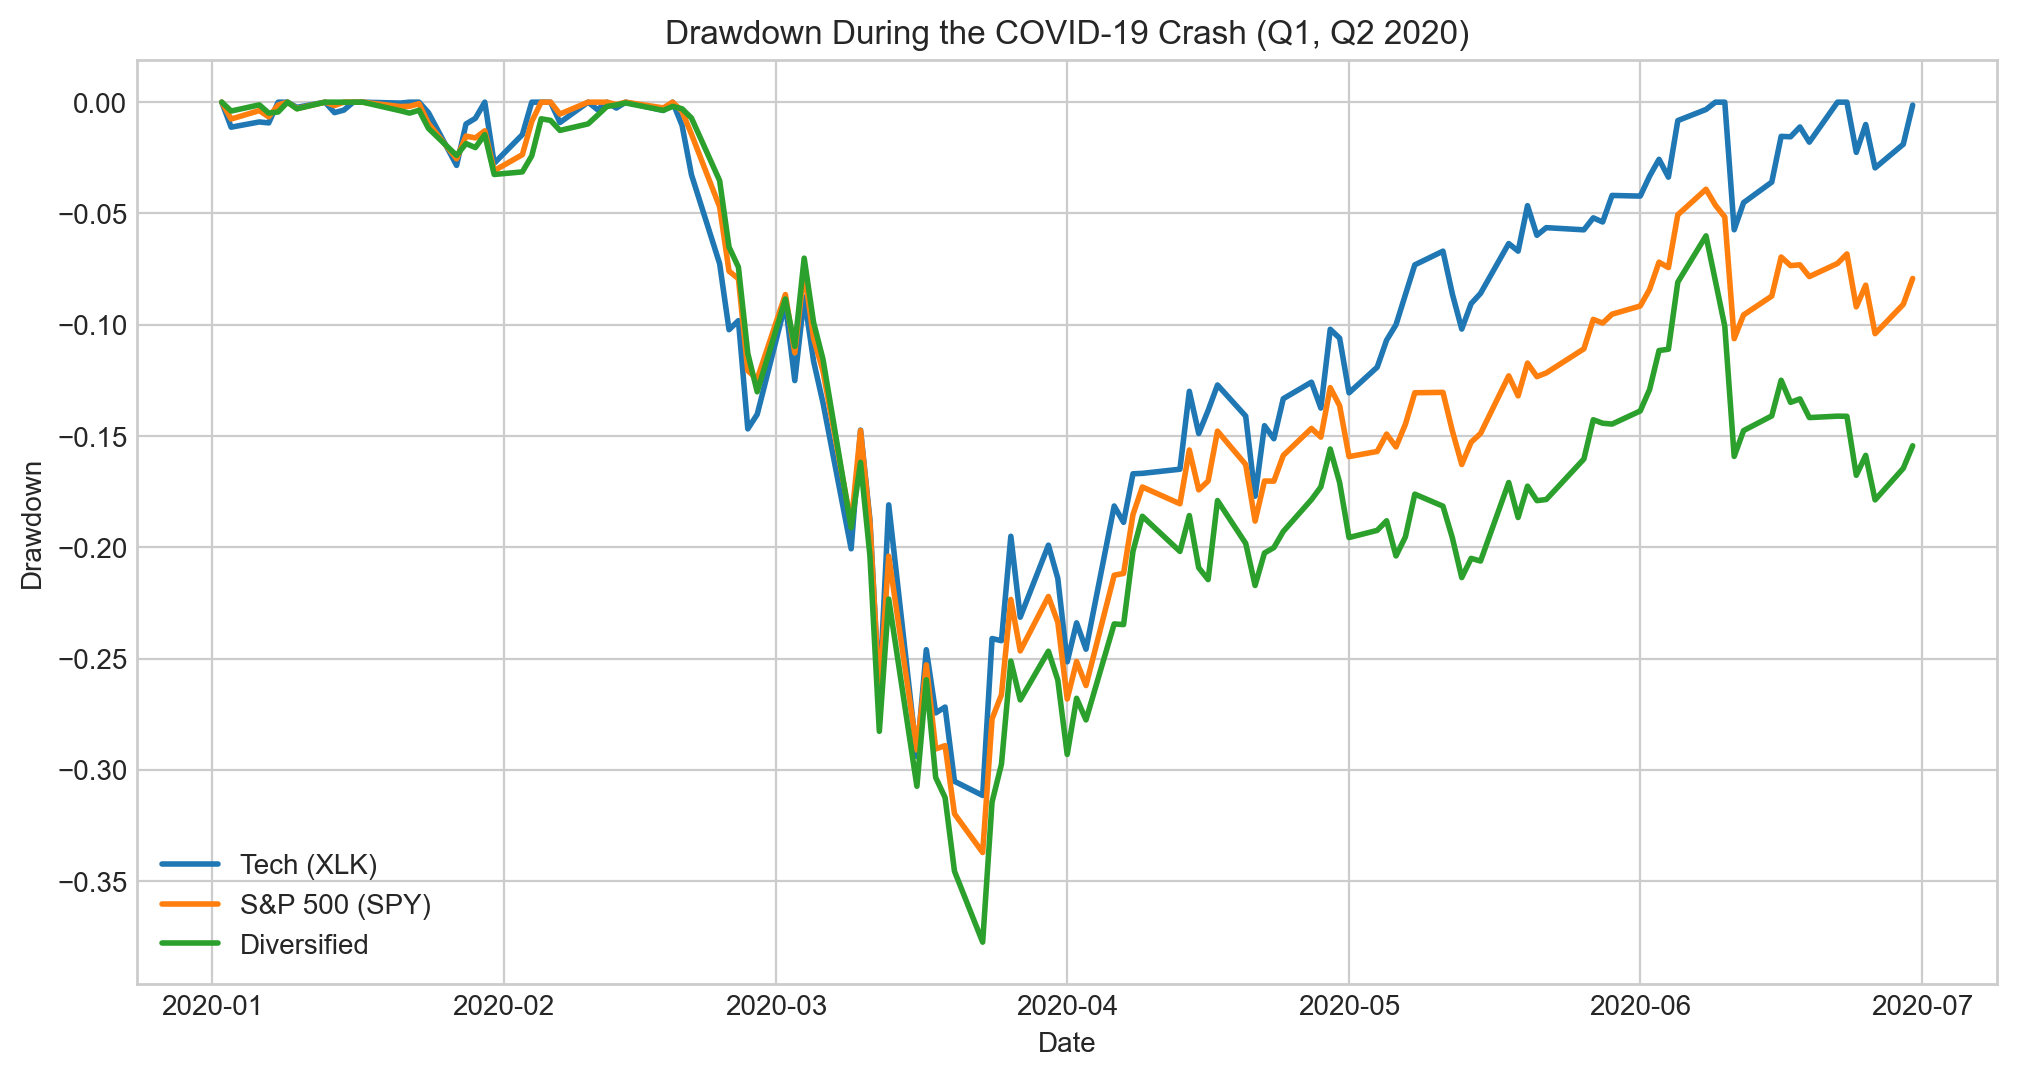

In [45]:
drawdown_series = pd.DataFrame({
    'tech_dd': tech_dd_series,
    'bench_dd': bench_dd_series,
    'div_dd': div_dd_series
})

#Create a mask for the first half of 2020 (COVID Crash)
mask_h1_2020 = (drawdown_series.index >= '2020-01-01') & (drawdown_series.index < '2020-07-01')
dd_h1_2020 = drawdown_series.loc[mask_h1_2020]

plt.figure(figsize=(12, 6))
plt.plot(dd_h1_2020['tech_dd'], label='Tech (XLK)', linewidth=2)
plt.plot(dd_h1_2020['bench_dd'], label='S&P 500 (SPY)', linewidth=2)
plt.plot(dd_h1_2020['div_dd'], label='Diversified', linewidth=2)

plt.title('Drawdown During the COVID-19 Crash (Q1, Q2 2020)')
plt.ylabel('Drawdown')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

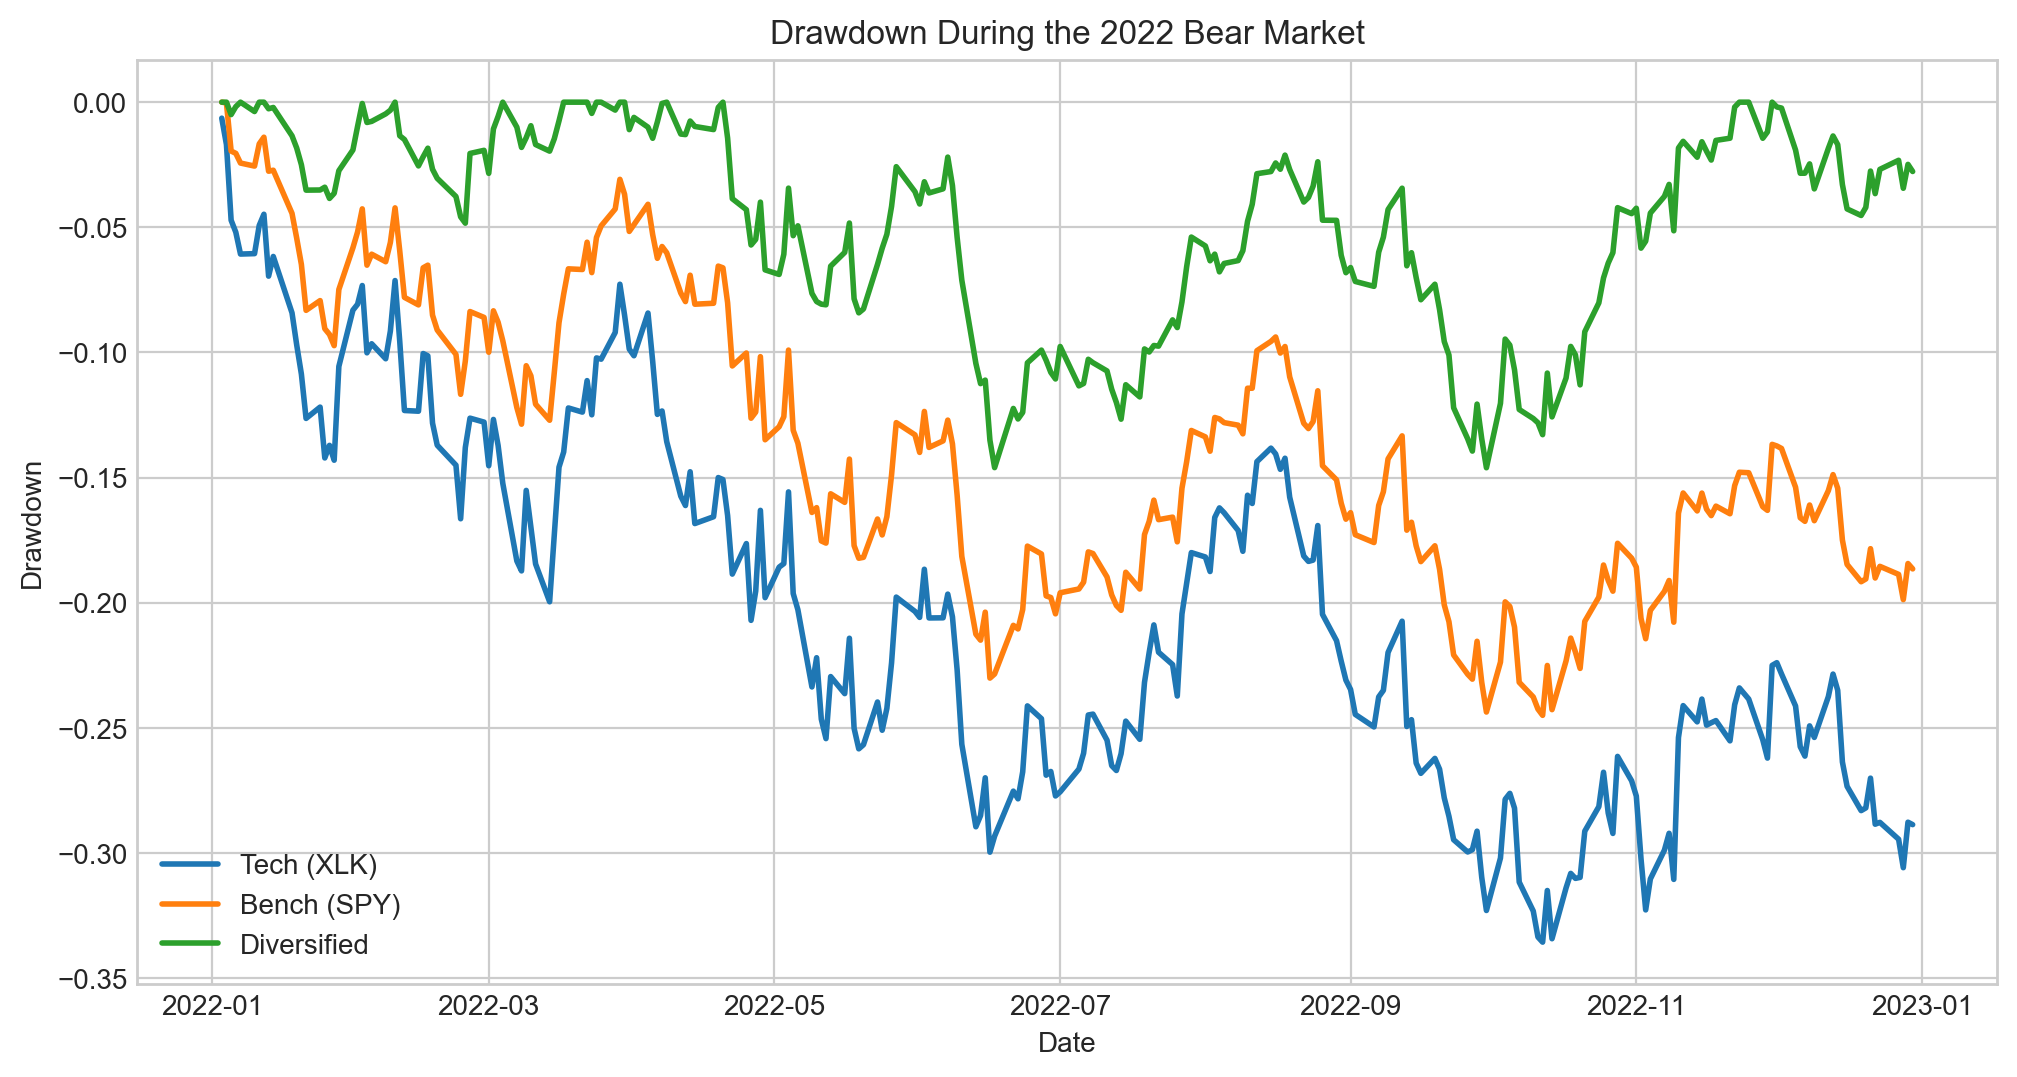

In [47]:
#Create a mask to filter for dates in 2022
mask_2022 = (drawdown_series.index >= '2022-01-01') & (drawdown_series.index < '2023-01-01')
dd_2022 = drawdown_series.loc[mask_2022]

plt.figure(figsize=(12, 6))
plt.plot(dd_2022['tech_dd'], label='Tech (XLK)', linewidth=2)
plt.plot(dd_2022['bench_dd'], label='Bench (SPY)', linewidth=2)
plt.plot(dd_2022['div_dd'], label='Diversified', linewidth=2)

plt.title('Drawdown During the 2022 Bear Market')
plt.ylabel('Drawdown')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()